In [3]:
%matplotlib inline
import os
import os.path
import cv2
import glob
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

- HSV即色相、饱和度、明度（英语：Hue, Saturation, Value

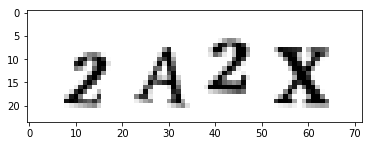

In [4]:
image = cv2.imread("2A2X.png")
plt.imshow(image)
#轉換顏色空間
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
#thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)[1]
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

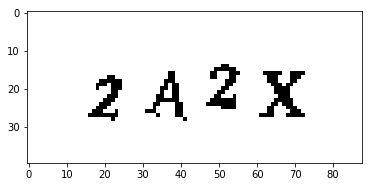

In [5]:
save_path = os.path.join("C:\\Users\\MLUSER\\Documents\\GitHub")
p = os.path.join(save_path, "2A2X.png")
cv2.imwrite(p, thresh)
image = cv2.imread("C:\\Users\\MLUSER\\Documents\\GitHub\\2A2X.png")
plt.imshow(image)

cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
- BORDER_CONSTANT: 使用常数填充边界 (i.e. 黑色或者 0)
- BORDER_REPLICATE: 复制原图中最临近的行或者列。

 http://monkeycoding.com/?p=600
 
 threshold(InputArray src, OutputArray dst, double thresh, double maxval, int type)

src：輸入圖，只能輸入單通道，8位元或32位元浮點數影像。

dst：輸出圖，尺寸大小、深度會和輸入圖相同。

thresh：閾值。

maxval：二值化結果的最大值。

type：二值化操作型態，共有THRESH_BINARY、THRESH_BINARY_INV、THRESH_TRUNC、THRESH_TOZERO、THRESH_TOZERO_INV五種。

type從上述五種結合CV_THRESH_OTSU，類似寫成：THRESH_BINARY | CV_THRESH_OTSU

In [6]:
#thresh = cv2.threshold(gray, 0, 255,  cv2.THRESH_OTSU)[1]
#print (thresh[1])
#plt.imshow(thresh)
type(thresh)

numpy.ndarray

In [7]:
# find the contours (continuous blobs of pixels) the image
# https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hack for compatibility with different OpenCV versions
contours = contours[0] if imutils.is_cv2() else contours[1]

save_path = os.path.join("C:\\Users\\MLUSER\\Documents\\GitHub")
p = os.path.join(save_path, "2A2X.png")
#cv2.imwrite(p,contours)
#image = cv2.imread("C:\\Users\\MLUSER\\Documents\\GitHub\\2A2X.png")

In [8]:
letter_image_regions = []
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    # print (x,y,w,h)
    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    pass
    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

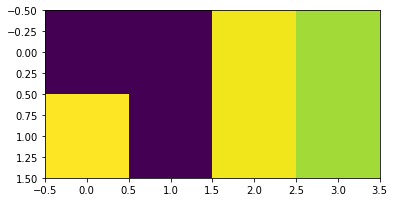

In [9]:
plt.imshow(letter_image_regions)

In [10]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit

In [11]:
from sklearn.preprocessing import LabelBinarizer

In [25]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit


LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)


In [ ]:

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)


In [26]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.core import Flatten, Dense
from helpers import resize_to_fit
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D 

In [37]:



LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)


inp = Input(shape=(20,20,1))
flat = Flatten()(ip)
Dense1 = Dense(1000, activation='relu')(flat)
Drop1 = Dropout(0.2)(Dense1)
Dense2 = Dense(512, activation='relu')(Drop1)
Drop2 = Dropout(0.2)(Dense2)
Dense3 = Dense(32, activation='softmax')(Drop2)      
model = Model(inp,Dense3)

model.summary()
"""
model = Sequential()

model.add(Flatten(input_shape=(20, 20, 1)))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))
"""


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 20, 20, 1)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1000)              401000    
_________________________________________________________________
dropout_31 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                16416     
Total para

'\nmodel = Sequential()\n\nmodel.add(Flatten(input_shape=(20, 20, 1)))\nmodel.add(Dense(1000, activation=\'relu\'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(512, activation=\'relu\'))\nmodel.add(Dropout(0.2))\n# Output layer with 32 nodes (one for each possible letter/number we predict)\nmodel.add(Dense(32, activation="softmax"))\n'

In [38]:

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)

# Save the trained model to disk
model.save(MODEL_FILENAME)

Train on 29058 samples, validate on 9686 samples
Epoch 1/10
29058/29058 [==============================] - 66s - loss: 0.4724 - acc: 0.8749 - val_loss: 0.0909 - val_acc: 0.9822
Epoch 2/10
29058/29058 [==============================] - 64s - loss: 0.0933 - acc: 0.9776 - val_loss: 0.0456 - val_acc: 0.9896
Epoch 3/10
29058/29058 [==============================] - 69s - loss: 0.0731 - acc: 0.9798 - val_loss: 0.0597 - val_acc: 0.9859
Epoch 4/10
29058/29058 [==============================] - 69s - loss: 0.0651 - acc: 0.9815 - val_loss: 0.0390 - val_acc: 0.9898
Epoch 5/10
29058/29058 [==============================] - 62s - loss: 0.0568 - acc: 0.9835 - val_loss: 0.0320 - val_acc: 0.9916
Epoch 6/10
29058/29058 [==============================] - 61s - loss: 0.0545 - acc: 0.9832 - val_loss: 0.0311 - val_acc: 0.9925
Epoch 7/10
29058/29058 [==============================] - 61s - loss: 0.0397 - acc: 0.9883 - val_loss: 0.0260 - val_acc: 0.9929
Epoch 8/10
29058/29058 [==============================]

In [39]:
from keras.models import load_model
from helpers import resize_to_fit
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle


MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text 
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    cv2.imshow("Output", output)
    cv2.waitKey()

CAPTCHA text is: K3WB
CAPTCHA text is: FZQP
CAPTCHA text is: FNS2
CAPTCHA text is: KZT3
CAPTCHA text is: PN22
CAPTCHA text is: V2NZ
CAPTCHA text is: 59H8
CAPTCHA text is: KBFS
CAPTCHA text is: M3LP
CAPTCHA text is: 8YDS
